### Refernces



*   [Basic architecture of SGU](https://github.com/labmlai/annotated_deep_learning_paper_implementations/tree/master/labml_nn/transformers/gmlp)
*   [Original Paper](https://arxiv.org/abs/2105.08050)
*   [MLP](https://medium.com/deep-learning-study-notes/multi-layer-perceptron-mlp-in-pytorch-21ea46d50e62)



# Importing Libraries

In [ ]:
import time

import pandas as pd
import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder


# Reading Data

In [ ]:
# trainlabels.csv should be in same directory as notebook
# To run the model on the whole dataset, remove [:1000]

df = pd.read_csv("trainLabels.csv")[:1000]
df

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
995,996,cat
996,997,dog
997,998,automobile
998,999,cat


In [ ]:
df.columns

Index(['id', 'label'], dtype='object')

In [ ]:
df["label"].unique()

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

In [ ]:
# there are 10 classes/labels in dataset
len(df["label"].unique())

10

In [ ]:
# Creating a LabelEncoder object
le = LabelEncoder()

# Fit and transform the categorical data
# converting categorical labels to numerical
df['label'] = le.fit_transform(df['label'])

In [ ]:
df["label"].unique()

array([6, 9, 4, 1, 2, 7, 8, 3, 5, 0])

In [ ]:
df

,id,label
0,1,6
1,2,9
2,3,9
3,4,4
4,5,1
...,...,...
995,996,3
996,997,5
997,998,1
998,999,3


# Dataset and Dataloader

In [ ]:
# Change the path to the same directory and in the form of: (your path)/gMLP/train/
# The train folder should be in same directory as notebook

class custom_Dataset(Dataset):

    def __init__(self, df, freq_threshold = 5):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        transform = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor(),transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))])
        image = Image.open("C:/Users/HP/Desktop/gMLP/train/"+ str(self.df.iloc[index, 0])+".png").convert("RGB")
        image = transform(image)

        sentiment = torch.tensor(int(self.df.iloc[index, 1]))

        temp = [image, sentiment]

        return temp

In [ ]:
dataset = custom_Dataset(df)
dataset

In [ ]:
len_dataset = len(dataset)
print("length of dataset : ",len_dataset)
print("80% of dataset: ",0.8*len_dataset)
print("20% of dataset: ",len_dataset-(0.8*len_dataset))

length of dataset :  1000
80% of dataset:  800.0
20% of dataset:  200.0


In [ ]:
# In the length =[x,y] the x should be 80% and y should be 20% of the entire dataset (train and test)

generator = torch.Generator()
generator.manual_seed(0)
train_set, test_set = random_split(dataset=dataset, lengths=[800,200],generator=generator)

training_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle=True)
testing_loader = DataLoader(dataset = test_set, batch_size = 64, shuffle=True)

In [ ]:
dd = list(training_loader)
images, labels = dd[0]
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64])


# Architecture of gMLP

In [ ]:
# d_ffn is the dimensionality of Z
# seq_len is the length of the img sequence (n)

# The paper notes that it's important to initialize bias to 1.

# chunk splits x into u and v

# v needs to be normalized and projected according to formula in paper


class SpatialGatingUnit(nn.Module):
    def __init__(self, d_ffn, seq_len):
        super().__init__()
        self.norm = nn.LayerNorm(d_ffn)
        self.spatial_proj = nn.Conv1d(seq_len, seq_len, kernel_size=1)
        nn.init.constant_(self.spatial_proj.bias, 1.0)

    def forward(self, x):
        u, v = x.chunk(2, dim=-1)
        v = self.norm(v)
        v = self.spatial_proj(v)
        out = u * v
        return out

For gMLPBlock()
Each block does the following transformations to input embeddings X∈R
n×d where n is the sequence length and d is the dimensionality of the embeddings:

Z=σ(XU)
Z'=s(Z)
Y= Z'V
where V and U are learnable projection weights. s(⋅) is the Spacial Gating Unit defined below. Output dimensionality of s(⋅) will be half of Z. σ is an activation function such as GeLU.

In [ ]:
#     d_model is the dimensionality (d) of X
#     d_ffn is the dimensionality of Z
#     seq_len is the length of the img sequence (n)

class gMLPBlock(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.channel_proj1 = nn.Linear(d_model, d_ffn * 2)
        self.channel_proj2 = nn.Linear(d_ffn, d_model)
        self.sgu = SpatialGatingUnit(d_ffn, seq_len)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = F.gelu(self.channel_proj1(x))
        x = self.sgu(x)
        x = self.channel_proj2(x)
        out = x + residual
        return out

In [ ]:
class gMLP(nn.Module):
    def __init__(self, d_model=256, d_ffn=512, seq_len=256, num_layers=6):
        super().__init__()
        self.model = nn.Sequential(
            *[gMLPBlock(d_model, d_ffn, seq_len) for _ in range(num_layers)]
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# This function checks whether image_size is divisible by patch_size(remainder of 0 is necessary)

def check_sizes(image_size, patch_size):
    sqrt_num_patches, remainder = divmod(image_size, patch_size)
    assert remainder == 0,
    num_patches = sqrt_num_patches ** 2
    return num_patches

In [ ]:
# in_channels is 3 because of RGB
# num_classes is 10 as there are 10 labels
# the shape is like (batch size,Colour channel,img size,img size)


class gMLPForImageClassification(gMLP):
    def __init__(self, image_size=256, patch_size=16, in_channels=3,num_classes=10,d_model=256,d_ffn=512,seq_len=256,num_layers=6):
        num_patches = check_sizes(image_size, patch_size)
        super().__init__(d_model, d_ffn, seq_len, num_layers)
        self.patcher = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        patches = self.patcher(x)
        batch_size, num_channels, _, _ = patches.shape
        patches = patches.permute(0, 2, 3, 1)
        patches = patches.view(batch_size, -1, num_channels)
        embedding = self.model(patches)
        embedding = embedding.mean(dim=1)
        out = self.classifier(embedding)
        return out

In [ ]:
model = gMLPForImageClassification()


# Training and Validation

Learning rate scheduling:
Learning rate scheduler -> change the learning rate after every batch of training.
"One Cycle Learning Rate Policy" -> starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% epochs, then gradually decreasing it to a very low value for the remaining epochs.


Weight decay: Regularization technique to prevent the weights from becoming too large by adding an additional term to the loss function


Gradient clipping: it's helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values.

In [ ]:
def prediction(data_loader, model, criterion):
    correct = 0
    total = 0
    losses = 0

    for i, (images, labels) in enumerate(data_loader):

        outputs = model(images)

        loss = criterion(outputs, labels)

        _, predictions = torch.max(outputs, dim=1)

        correct += torch.sum(labels == predictions).item()
        total += labels.shape[0]

        losses += loss.data.item()

    return losses/len(list(data_loader)), 1 - correct/total # we need to normalize loss with respect to the number of batches

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
# define a fit_one_cycle function to incorporate learning rate scheduling, weight decay and gradient clipping
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, criterion,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []

  # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))


    train_losses = []
    test_losses = []

    train_error_rates = []
    test_error_rates = []

  # Loop through all epochs
    for epoch in range(epochs):
        train_loss = 0
        n_iter = 0
        total = 0
        correct = 0
        lrs = []

        # Training phase
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad() # zero gradients out before computing others

            outputs = model(images)

          # compute the train_error rates
            _, predictions = torch.max(outputs, 1)
            correct += torch.sum(labels == predictions).item()
            total += labels.shape[0]

          # compute loss
            loss = criterion(outputs, labels)
          # compute gradients
            loss.backward()

          # Gradient clipping:
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

          # update weights/parameters
            optimizer.step()

          # record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

            train_loss += loss.detach().item()

            n_iter += 1

        train_error_rate = 1 - correct/total

        # Validation phase
        with torch.no_grad():
            test_loss, test_error_rate = prediction(val_loader, model, criterion)

        train_error_rates.append(train_error_rate)
        test_error_rates.append(test_error_rate)
        train_losses.append(train_loss/n_iter)
        test_losses.append(test_loss)
        results ={'train_loss': train_loss/n_iter,'val_loss': test_loss, 'val_acc': (1-train_error_rate)*100}
        results['lrs'] = lrs
        history.append(results)

        print('Epoch: {}/{}, last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.1f}%'.format(epoch+1, epochs, results['lrs'][-1], train_loss/n_iter, test_loss, (1-train_error_rate)*100))

    return history

In [ ]:
# Hyperparameters
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
criterion = nn.CrossEntropyLoss()

In [ ]:
history_mlp = fit_one_cycle(epochs, max_lr, model, training_loader, testing_loader, criterion, weight_decay, opt_func=opt_func)

Epoch: 1/5, last_lr: 0.00736, train_loss: 2.8115, val_loss: 3.1678, val_accuracy: 21.5%
Epoch: 2/5, last_lr: 0.00950, train_loss: 4.0386, val_loss: 6.5856, val_accuracy: 14.6%
Epoch: 3/5, last_lr: 0.00611, train_loss: 6.9836, val_loss: 4.8457, val_accuracy: 13.0%
Epoch: 4/5, last_lr: 0.00188, train_loss: 3.5347, val_loss: 2.9927, val_accuracy: 21.3%
Epoch: 5/5, last_lr: 0.00000, train_loss: 2.2894, val_loss: 2.2387, val_accuracy: 29.1%


# Model Evaluation

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]

    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    test_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, label='train', marker='o', alpha=0.7)
    plt.plot(test_losses, label='test', marker='o', alpha=0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.title('Model Loss')

Text(0.5, 1.0, 'Accuracy')

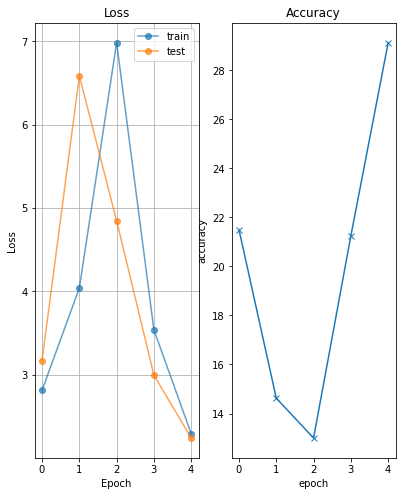

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1,3,1)
plot_losses(history_mlp)
plt.title('Loss')
plt.subplot(1,3,2)
plot_accuracies(history_mlp)
plt.title('Accuracy')

# Testing/output

GroundTruth:  ship
GroundTruth:  deer
GroundTruth:  horse
GroundTruth:  bird
GroundTruth:  truck


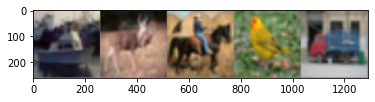

In [ ]:
dd = list(training_loader)
images, labels = dd[0]
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(torchvision.utils.make_grid(images[:5]))
labels = le.inverse_transform(labels)
for j in range(5):
    print('GroundTruth: ',labels[j])

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)
predicted = le.inverse_transform(predicted)
for j in range(5):
    print('Predicted: ',predicted[j])

Predicted:  truck
Predicted:  horse
Predicted:  horse
Predicted:  deer
Predicted:  automobile


This is a classification model and model outputs values from 0 to 9 as there are 10 classes. these values needs to be mapped to original labales such as cat,truck,etc.